In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from os import listdir
from os.path import exists

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Récupération des données

In [5]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [6]:
data = pd.read_csv(path_csv)

## Visualisation du dataset

In [7]:
data.describe(datetime_is_numeric=True, include='all').T

count unique  \
uniq_id                    1050   1050   
crawl_timestamp            1050    149   
product_url                1050   1050   
product_name               1050   1050   
product_category_tree      1050    642   
pid                        1050   1050   
retail_price             1049.0    NaN   
discounted_price         1049.0    NaN   
image                      1050   1050   
is_FK_Advantage_product    1050      2   
description                1050   1050   
product_rating             1050     27   
overall_rating             1050     27   
brand                       712    490   
product_specifications     1049    984   

                                                                       top  \
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                  2015-12-01 12:40:44 +0000   
product_url              http://www.flipkart.com/elegance-polyester-mul...   
product_name             Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree    ["Home Furnishing >> Bed Linen >> Blankets, Qu...   
pid                                                       CRNEG7BKMFFYHQ8Z   
retail_price                                                           NaN   
discounted_price                                                       NaN   
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg   
is_FK_Advantage_product                                              False   
description              Key Features of Elegance Polyester Multicolor ...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                         PRINT SHAPES   
product_specifications   {"product_specification"=>[{"key"=>"Type", "va...   

                        freq         mean          std   min    25%    50%  \
uniq_id                    1          NaN          NaN   NaN    NaN    NaN   
crawl_timestamp          150          NaN          NaN   NaN    NaN    NaN   
product_url                1          NaN          NaN   NaN    NaN    NaN   
product_name               1          NaN          NaN   NaN    NaN    NaN   
product_category_tree     56          NaN          NaN   NaN    NaN    NaN   
pid                        1          NaN          NaN   NaN    NaN    NaN   
retail_price             NaN  2186.197331  7639.229411  35.0  555.0  999.0   
discounted_price         NaN  1584.527169   7475.09968  35.0  340.0  600.0   
image                      1          NaN          NaN   NaN    NaN    NaN   
is_FK_Advantage_product  993          NaN          NaN   NaN    NaN    NaN   
description                1          NaN          NaN   NaN    NaN    NaN   
product_rating           889          NaN          NaN   NaN    NaN    NaN   
overall_rating           889          NaN          NaN   NaN    NaN    NaN   
brand                     11          NaN          NaN   NaN    NaN    NaN   
product_specifications    22          NaN          NaN   NaN    NaN    NaN   

                            75%       max  
uniq_id                     NaN       NaN  
crawl_timestamp             NaN       NaN  
product_url                 NaN       NaN  
product_name                NaN       NaN  
product_category_tree       NaN       NaN  
pid                         NaN       NaN  
retail_price             1999.0  201000.0  
discounted_price         1199.0  201000.0  
image                       NaN       NaN  
is_FK_Advantage_product     NaN       NaN  
description                 NaN       NaN  
product_rating              NaN       NaN  
overall_rating              NaN       NaN  
brand                       NaN       NaN  
product_specifications      NaN       NaN

In [8]:
@interact
def show_data(key=data.columns):
    return data[key]

interactive(children=(Dropdown(description='key', options=('uniq_id', 'crawl_timestamp', 'product_url', 'produ…

In [9]:
# Visualisation feature par feature des NaN et catégories
data_summary = pd.DataFrame(
    {},
)


data_tmp = pd.DataFrame(
    {},
)
data_tmp["feature"] = data.columns
data_tmp["qtd_null"] = data.isnull().sum().values
data_tmp["%_null"] = (100 * data.isnull().sum() / data.shape[0]).values
data_tmp["dtype"] = data.dtypes.values
data_tmp["qtd_cat"] = [
    n if t == "object" else 0 for n, t in zip(data.nunique(), data.dtypes)
]

data_summary = pd.concat([data_summary, data_tmp], ignore_index=True)

data_summary.style.background_gradient(cmap="YlGnBu", axis=0)

Valeurs extrèmes des prix

In [10]:
data.sort_values('retail_price', ascending=False).head(10)

uniq_id            crawl_timestamp  \
11   08452abdadb3db1e686b94a9c52fc7b6  2015-12-04 07:25:36 +0000   
9    710ed5f2393a4b9e8823aa0029f71f93  2015-12-04 07:25:36 +0000   
604  85aec4bf3185da7ebcc45003429cbfe2  2016-01-07 04:32:43 +0000   
605  bcb8e456728013a90ba66ab3b1b783ad  2016-01-07 04:32:43 +0000   
318  fd2716d0e5dd7ffc367ca4dd9f97aaa0  2015-12-01 06:13:00 +0000   
437  b6c339777814451815fe7950fd4c8536  2016-06-16 08:51:06 +0000   
329  cb0afa31d9ca796908fde019cd64044d  2015-12-01 06:13:00 +0000   
5    893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
90   6ae332e2bafd23267caedfcc4453257c  2016-01-04 00:20:04 +0000   
606  afc829d45be38102afaa20f4bce2f627  2016-03-12 14:25:06 +0000   

                                           product_url  \
11   http://www.flipkart.com/cartier-w6701005-analo...   
9    http://www.flipkart.com/tag-heuer-cau1116-ba08...   
604  http://www.flipkart.com/hp-15-ac116tx-notebook...   
605  http://www.flipkart.com/hp-15-ac121tu-notebook...   
318  http://www.flipkart.com/asus-wireless-ac2400-d...   
437  http://www.flipkart.com/homeedge-solid-wood-ki...   
329  http://www.flipkart.com/asus-rt-ac68u-dual-ban...   
5    http://www.flipkart.com/maserati-time-r8851116...   
90   http://www.flipkart.com/exotic-india-adi-buddh...   
606  http://www.flipkart.com/soulful-threads-red-th...   

                                          product_name  \
11      Cartier W6701005 Analog Watch  - For Boys, Men   
9    TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   
604  HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4...   
605  HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4...   
318      Asus Wireless AC2400 Dual-band Gigabit Router   
437                       HomeEdge Solid Wood King Bed   
329  Asus RT-AC68U Dual-band Wireless-AC1900 Gigabi...   
5    Maserati Time R8851116001 Analog Watch  - For ...   
90   Exotic India Adi Buddha Vajrasattva Showpiece ...   
606  Soulful Threads Red Thread Aari Embroidered Bl...   

                                 product_category_tree               pid  \
11   ["Watches >> Wrist Watches >> Cartier Wrist Wa...  WATEAK8SE2RUK7GM   
9    ["Watches >> Wrist Watches >> TAG Heuer Wrist ...  WATEA6UGFGKZKDJC   
604             ["Computers >> Laptops >> HP Laptops"]  COMEAZ945RHFFGUS   
605             ["Computers >> Laptops >> HP Laptops"]  COMEAZ94HWYQTZHZ   
318  ["Computers >> Network Components >> Routers >...  RTREYTY2TMVNXZG4   
437  ["Beauty and Personal Care >> Health Care >> H...  BDDEH93ZEEZY7CHM   
329  ["Computers >> Network Components >> Routers >...  RTRDRDPR9JHCSBGH   
5    ["Watches >> Wrist Watches >> Maserati Time Wr...  WATEAYAHJ8CUCAYM   
90   ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE3QDHGXSE3PYE   
606  ["Beauty and Personal Care >> Makeup >> Vanity...  VANEGPA7ZKGT2UUH   

     retail_price  discounted_price                                 image  \
11       201000.0          201000.0  08452abdadb3db1e686b94a9c52fc7b6.jpg   
9        107750.0          107750.0  710ed5f2393a4b9e8823aa0029f71f93.jpg   
604       38890.0           38890.0  85aec4bf3185da7ebcc45003429cbfe2.jpg   
605       35390.0           35390.0  bcb8e456728013a90ba66ab3b1b783ad.jpg   
318       29990.0           21290.0  fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg   
437       25499.0           18799.0  b6c339777814451815fe7950fd4c8536.jpg   
329       25000.0           13390.0  cb0afa31d9ca796908fde019cd64044d.jpg   
5         24400.0           24400.0  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
90        22525.0           21800.0  6ae332e2bafd23267caedfcc4453257c.jpg   
606       21125.0            1700.0  afc829d45be38102afaa20f4bce2f627.jpg   

     is_FK_Advantage_product  \
11                     False   
9                      False   
604                     True   
605                     True   
318                    False   
437                    False   
329                    False   
5                      False   
90                     False  

In [11]:
data.sort_values('discounted_price', ascending=False).head(10)

uniq_id            crawl_timestamp  \
11   08452abdadb3db1e686b94a9c52fc7b6  2015-12-04 07:25:36 +0000   
9    710ed5f2393a4b9e8823aa0029f71f93  2015-12-04 07:25:36 +0000   
604  85aec4bf3185da7ebcc45003429cbfe2  2016-01-07 04:32:43 +0000   
605  bcb8e456728013a90ba66ab3b1b783ad  2016-01-07 04:32:43 +0000   
5    893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
90   6ae332e2bafd23267caedfcc4453257c  2016-01-04 00:20:04 +0000   
318  fd2716d0e5dd7ffc367ca4dd9f97aaa0  2015-12-01 06:13:00 +0000   
437  b6c339777814451815fe7950fd4c8536  2016-06-16 08:51:06 +0000   
124  640fd08bb3ba538d67a5c0c2c61a5c4c  2016-06-24 16:03:26 +0000   
97   18bd9b88e23b82fd19f8ab0c9cad6a1a  2016-01-04 00:20:04 +0000   

                                           product_url  \
11   http://www.flipkart.com/cartier-w6701005-analo...   
9    http://www.flipkart.com/tag-heuer-cau1116-ba08...   
604  http://www.flipkart.com/hp-15-ac116tx-notebook...   
605  http://www.flipkart.com/hp-15-ac121tu-notebook...   
5    http://www.flipkart.com/maserati-time-r8851116...   
90   http://www.flipkart.com/exotic-india-adi-buddh...   
318  http://www.flipkart.com/asus-wireless-ac2400-d...   
437  http://www.flipkart.com/homeedge-solid-wood-ki...   
124  http://www.flipkart.com/sos-computrised-lcd-in...   
97   http://www.flipkart.com/diviniti-dg-royal-orna...   

                                          product_name  \
11      Cartier W6701005 Analog Watch  - For Boys, Men   
9    TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   
604  HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4...   
605  HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4...   
5    Maserati Time R8851116001 Analog Watch  - For ...   
90   Exotic India Adi Buddha Vajrasattva Showpiece ...   
318      Asus Wireless AC2400 Dual-band Gigabit Router   
437                       HomeEdge Solid Wood King Bed   
124  SOS COMPUTRISED LCD INTRFERENTIAL UNIT-125PROG...   
97   Diviniti DG Royal Ornamental Size 4 Gurunanak ...   

                                 product_category_tree               pid  \
11   ["Watches >> Wrist Watches >> Cartier Wrist Wa...  WATEAK8SE2RUK7GM   
9    ["Watches >> Wrist Watches >> TAG Heuer Wrist ...  WATEA6UGFGKZKDJC   
604             ["Computers >> Laptops >> HP Laptops"]  COMEAZ945RHFFGUS   
605             ["Computers >> Laptops >> HP Laptops"]  COMEAZ94HWYQTZHZ   
5    ["Watches >> Wrist Watches >> Maserati Time Wr...  WATEAYAHJ8CUCAYM   
90   ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE3QDHGXSE3PYE   
318  ["Computers >> Network Components >> Routers >...  RTREYTY2TMVNXZG4   
437  ["Beauty and Personal Care >> Health Care >> H...  BDDEH93ZEEZY7CHM   
124  ["Beauty and Personal Care >> Health Care >> H...  ELTEJXM48D3HAUFB   
97   ["Home Decor & Festive Needs >> Table Decor & ...  SHIEBBWHSYHSVV4U   

     retail_price  discounted_price                                 image  \
11       201000.0          201000.0  08452abdadb3db1e686b94a9c52fc7b6.jpg   
9        107750.0          107750.0  710ed5f2393a4b9e8823aa0029f71f93.jpg   
604       38890.0           38890.0  85aec4bf3185da7ebcc45003429cbfe2.jpg   
605       35390.0           35390.0  bcb8e456728013a90ba66ab3b1b783ad.jpg   
5         24400.0           24400.0  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
90        22525.0           21800.0  6ae332e2bafd23267caedfcc4453257c.jpg   
318       29990.0           21290.0  fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg   
437       25499.0           18799.0  b6c339777814451815fe7950fd4c8536.jpg   
124       19500.0           17550.0  640fd08bb3ba538d67a5c0c2c61a5c4c.jpg   
97        17460.0           17460.0  18bd9b88e23b82fd19f8ab0c9cad6a1a.jpg   

     is_FK_Advantage_product  \
11                     False   
9                      False   
604                     True   
605                     True   
5                      False   
90                     False   
318                    False   
437                    False   
124                    False  

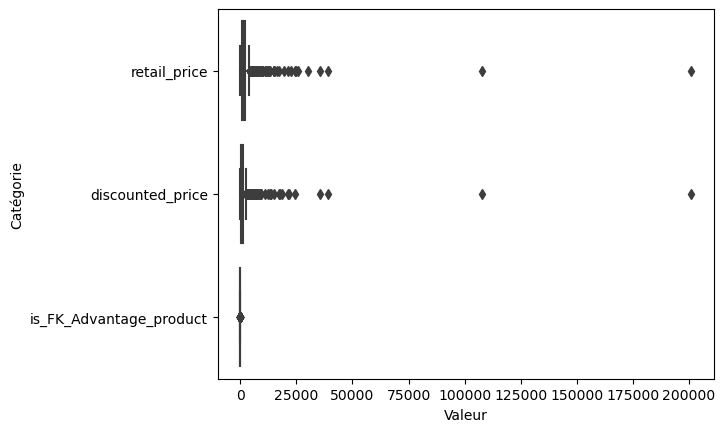

In [12]:
ax = sns.boxplot(data=data, orient="h")
ax.set(xlabel="Valeur", ylabel="Catégorie")

plt.show()

## Ajustement pour mon utilisation

In [13]:
# Récupère le noeud à la profondeur level
# (ou la feuille si level va trop profond)
def get_from_tree(tree, level):
    if len(tree) > level:
        return tree[level]
    else:
        return tree[-1]

Transformation de l'arbre de catégories

In [14]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [15]:
print("Nombre total de catégories possible (en comptant noeuds et feuilles) :")
print(len(data['product_category_list'].explode().unique()))

Nombre total de catégories possible (en comptant noeuds et feuilles) :
1126


In [16]:
print("Nombre total de catégories (feuilles) :")
print(len(data['product_category_tree'].unique()))

Nombre total de catégories (feuilles) :
642


In [17]:
tmp = data['product_category_list'].str.len()
print("Taille minimum d'un arbre :", tmp.min())
print("Taille maximum d'un arbre :", tmp.max())

Taille minimum d'un arbre : 2
Taille maximum d'un arbre : 7


Visualisation de ce même arbre

In [18]:
import graphviz

In [19]:
dot = graphviz.Digraph()

lien_deja = set()

# Ajouter la racine de l'arbre
dot.node('Racine')

for n in data['product_category_list'].explode().unique():
    dot.node(n)

def ajouter_lien(precedent, actuel, suite):
    nom = "{}/{}".format(precedent, actuel)
    if nom not in lien_deja:
        dot.edge(precedent, actuel)
        lien_deja.add(nom)
    
    if len(suite) > 0 :
        ajouter_lien(actuel, suite[0], suite[1:])

for l in data['product_category_list']:
    ajouter_lien('Racine', l[0], l[1:])

# Afficher l'arbre
# dot.render('categories', view=True)

## Visualisation des images
Premiers tests et mise en place des fonctions utiles

In [20]:
from IPython.display import display, HTML

In [21]:
def show_from_cv2_multi(images, titles):
    fig = plt.figure(figsize=(16, 16))
    cols = 2
    rows = len(images) // cols + 1
    for i, img in enumerate(images):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            plt.title(titles[i])
    
    plt.show()

In [22]:
def show_from_cv2(img):
    plt.figure(figsize=(7, 7))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.show()

In [23]:
print("Liste des ID non ratachés à une image existante :")
for name in data['image']:
    if not exists(path_img+'/'+name):
        print(uniq_id)

Liste des ID non ratachés à une image existante :


In [24]:
def path_to_image_html(name):
    return '<img src="'+ path_img + '/' + name + '" width="60" >'

display(HTML(data[['uniq_id', 'product_name', 'image']].head(11).to_html(escape=False ,formatters={'image':path_to_image_html}, col_space=2)))

In [25]:
@interact
def show_img(key=data.index):
    img = cv2.imread(path_img+'/'+data.loc[key, 'image'])
    return show_from_cv2(img)

interactive(children=(Dropdown(description='key', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

# Analyse préliminaire pour ORB

## Visualisation du traitement d'une image

In [26]:
id_ligne = 10
id_ligne = 0

In [27]:
ligne = data.iloc[id_ligne]

In [28]:
ligne

uniq_id                                     55b85ea15a1536d46b7190ad6fff8ce7
crawl_timestamp                                    2016-04-30 03:22:56 +0000
product_url                http://www.flipkart.com/elegance-polyester-mul...
product_name               Elegance Polyester Multicolor Abstract Eyelet ...
product_category_tree      ["Home Furnishing >> Curtains & Accessories >>...
pid                                                         CRNEG7BKMFFYHQ8Z
retail_price                                                          1899.0
discounted_price                                                       899.0
image                                   55b85ea15a1536d46b7190ad6fff8ce7.jpg
is_FK_Advantage_product                                                False
description                Key Features of Elegance Polyester Multicolor ...
product_rating                                           No rating available
overall_rating                                           No rating available

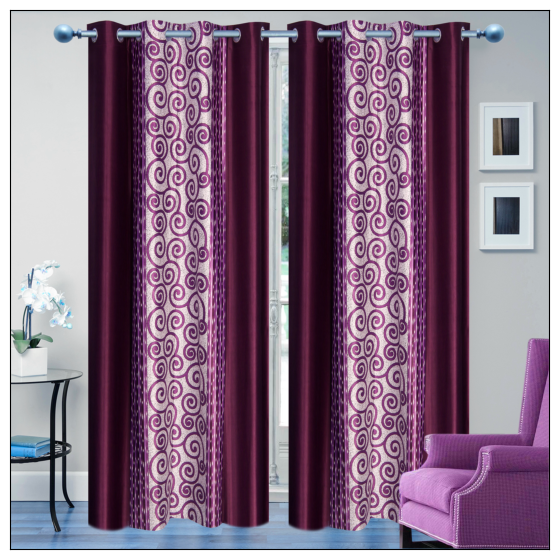

In [29]:
img = cv2.imread(path_img+'/'+ligne['image'])
show_from_cv2(img)

In [30]:
print("Taille de la matrice de pixels : {}".format(img.shape))

Taille de la matrice de pixels : (3600, 3600, 3)


Chargement de la version noir et blanc

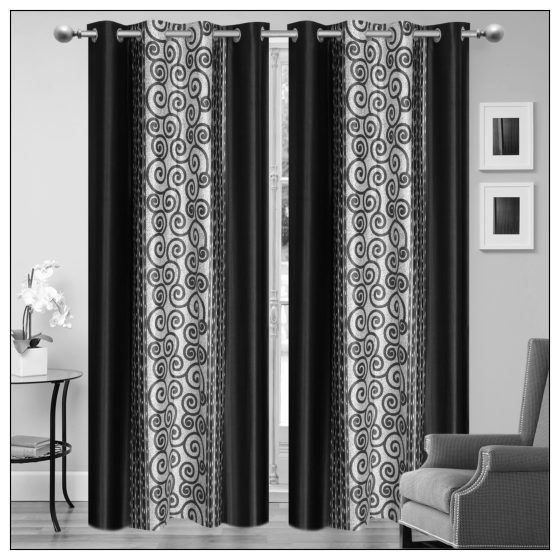

In [31]:
img = cv2.imread(path_img+'/'+ligne['image'], cv2.IMREAD_GRAYSCALE)
show_from_cv2(img)

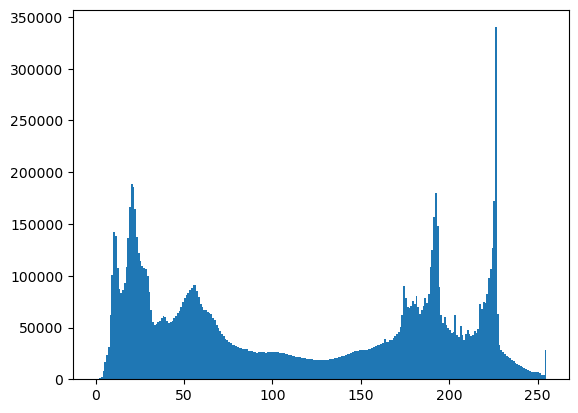

In [32]:
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Egalisation de l'image

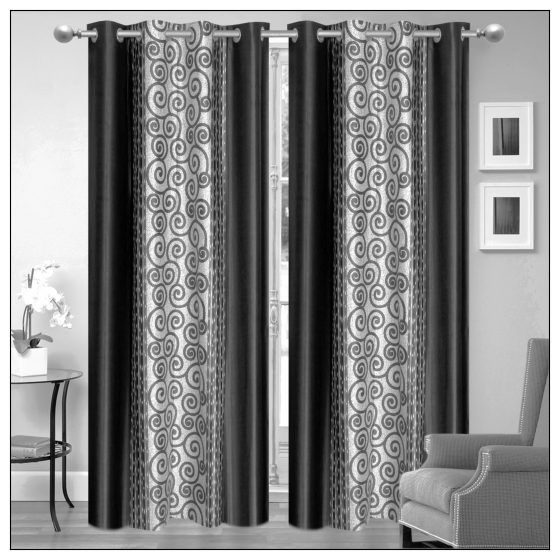

In [33]:
img_tmp = cv2.equalizeHist(img)
show_from_cv2(img_tmp)

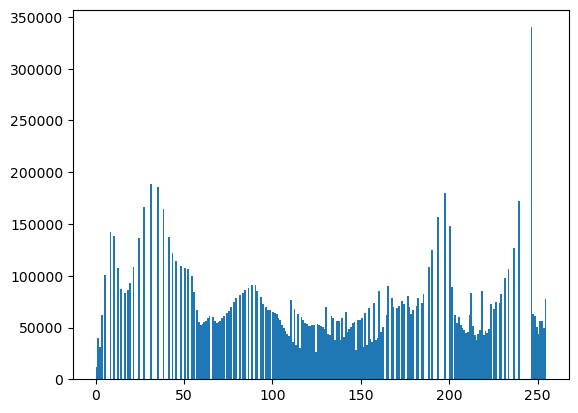

In [34]:
n, bins, patches = plt.hist(img_tmp.flatten(), bins=range(256))
plt.show()

Normalisation de l'image

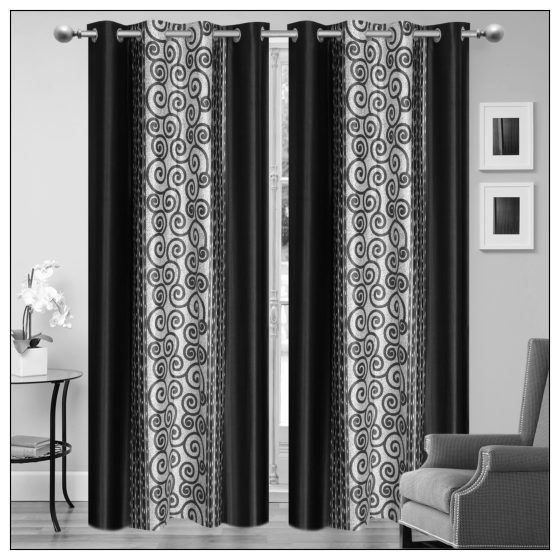

In [35]:
img_tmp = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
show_from_cv2(img_tmp)

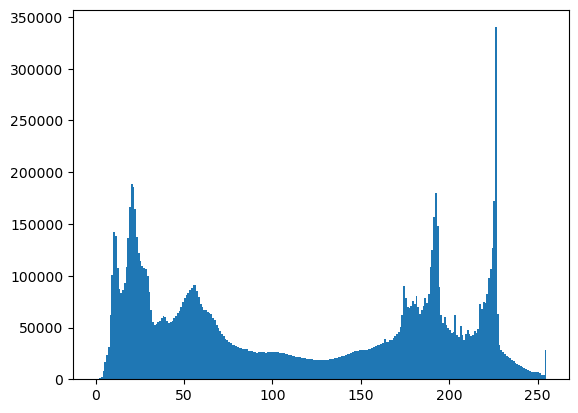

In [36]:
n, bins, patches = plt.hist(img_tmp.flatten(), bins=range(256))
plt.show()

Test d'ajout de flou

In [37]:
taille_filtre = 15

In [38]:
img = cv2.imread(path_img+'/'+ligne['image'], cv2.IMREAD_GRAYSCALE)
print(img.shape)
img = cv2.resize(img, (1000, 1000), interpolation= cv2.INTER_LINEAR)

(3600, 3600)


In [39]:
liste_test_img = []

In [40]:
liste_test_img.append(img)

In [41]:
liste_test_img.append(cv2.blur(img, (taille_filtre, taille_filtre)))

In [42]:
liste_test_img.append(cv2.GaussianBlur(img, (taille_filtre, taille_filtre), 0))

In [43]:
liste_test_img.append(cv2.medianBlur(img, taille_filtre))

In [44]:
liste_test_titles = ['Image de base', 'Flou classique', 'Flou Gaussien', 'Flou Médian']

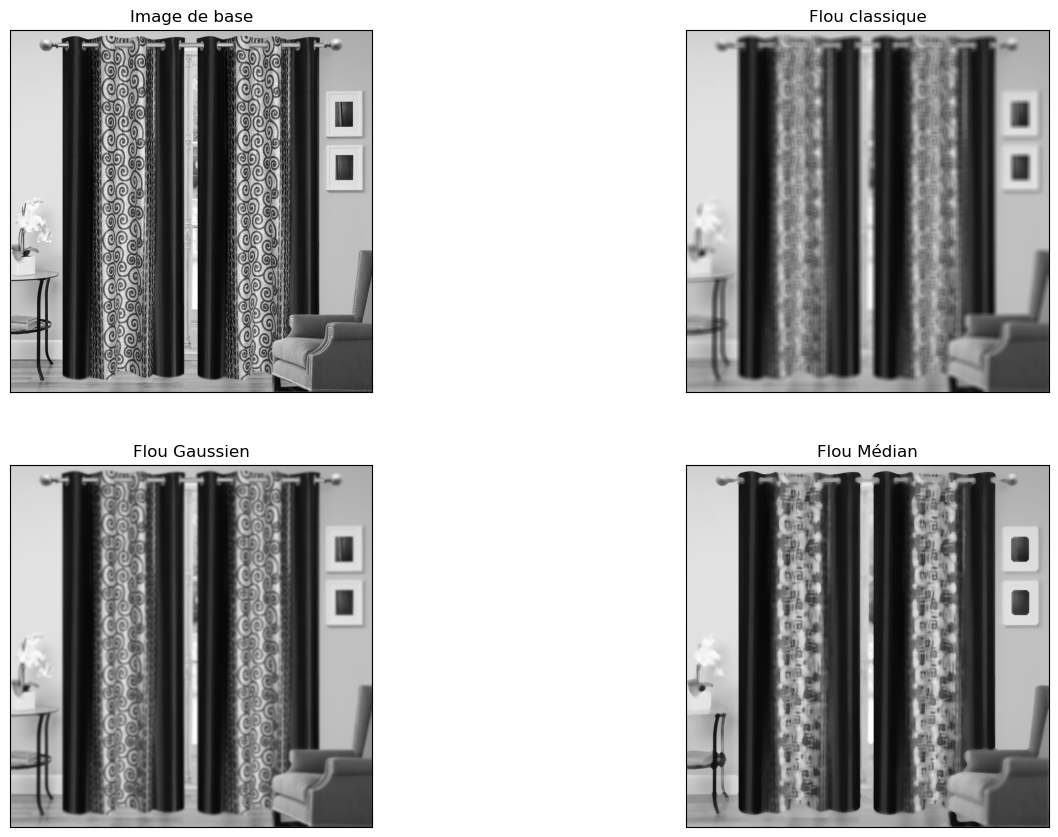

In [45]:
show_from_cv2_multi(liste_test_img, liste_test_titles)

## Visualisation d'une analyse ORB

In [46]:
nb_features = 256

In [47]:
img_tmp = cv2.equalizeHist(img)

In [48]:
orb = cv2.ORB_create(nfeatures=nb_features)

In [49]:
keypoints_orb, descriptors = orb.detectAndCompute(img_tmp, None)

In [50]:
img_keypoint = cv2.drawKeypoints(img, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

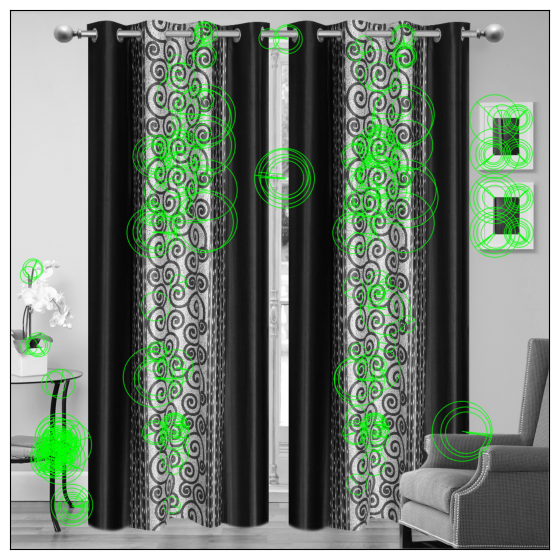

In [51]:
show_from_cv2(img_keypoint)

Comparaison avec les version floutés

In [52]:
liste_ORB = []
for img_tmp in liste_test_img:
    orb = cv2.ORB_create(nfeatures=50)
    keypoints_orb, descriptors = orb.detectAndCompute(img_tmp, None)
    img_keypoint = cv2.drawKeypoints(img_tmp, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    liste_ORB.append(img_keypoint)

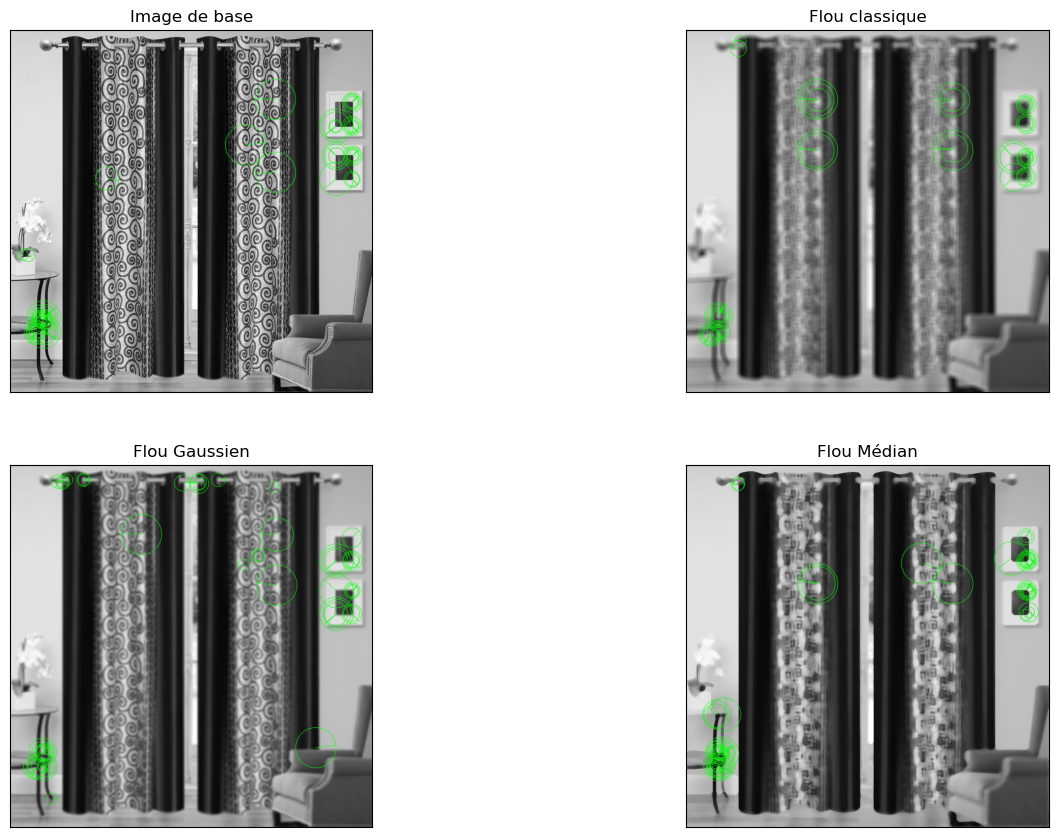

In [53]:
show_from_cv2_multi(liste_ORB, liste_test_titles)

In [54]:
tmp_size = int(0.01 * min(img_tmp.shape) / 2) * 2 + 1

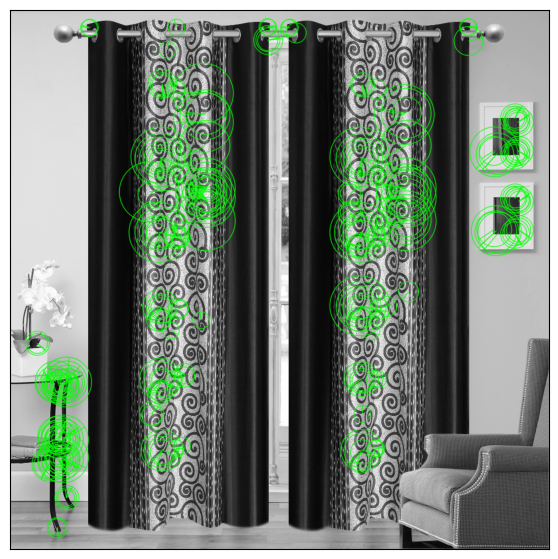

In [55]:
orb = cv2.ORB_create(nfeatures=nb_features)
keypoints_orb, descriptors = orb.detectAndCompute(cv2.GaussianBlur(img_tmp, (tmp_size, tmp_size), 0), None)
img_keypoint = cv2.drawKeypoints(img, keypoints_orb, 0, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_from_cv2(img_keypoint)

# Classification

In [56]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

## Filtrage du dataset
pour pouvoir tester en fonction du niveau choisi dans l'arbre ou du nombre de categories gardées

In [57]:
nb_cat = 20

In [58]:
level = -1

In [59]:
data_final = data[['image', 'product_category_list']].copy()

In [60]:
data_final.columns = ['img', 'cat_lst']

In [61]:
data_final['img'] = path_img+'/'+data_final['img']

In [62]:
data_final['cat'] = data_final['cat_lst'].apply(lambda tree : get_from_tree(tree, level))

In [63]:
data_final['cat'].value_counts().head(nb_cat)

Blankets, Quilts & Dohars                              56
Prithish Coffee Mugs                                   26
Maxima Wrist Watches                                   23
Rockmantra Coffee Mugs                                 22
Towels                                                 19
Sonata Wrist Watches                                   19
Printland Coffee Mugs                                  13
Times Wrist Watches                                    10
Oxyglow Combos and Kits                                10
Lal Haveli Ethnic                                      10
Cushion Covers                                         10
Lapguard Batteries                                     10
Curtains                                                9
Mxofere Combos and Kits                                 9
Perucci Wrist Watches                                   9
Timewel Wrist Watches                                   9
Denver Combos                                           8
Smartpro 19.5v

In [64]:
list_labels = list(data_final['cat'].value_counts().index)

In [65]:
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

In [66]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat])].copy().reset_index()

In [67]:
data_little

index                                                img  \
0      103  ./data/Flipkart/Images/dfbd96036cbc28566e964cf...   
1      104  ./data/Flipkart/Images/336fc49639a5cc45aa532ac...   
2      105  ./data/Flipkart/Images/789cf5578f48577a44586fc...   
3      107  ./data/Flipkart/Images/b515014adccb1fdf5ff1e2c...   
4      108  ./data/Flipkart/Images/5aacf8f5154afea2ac22fc7...   
..     ...                                                ...   
287    945  ./data/Flipkart/Images/8026dc3e27e8e318cc7431a...   
288    949  ./data/Flipkart/Images/f41761a931135c6c043c7e0...   
289    950  ./data/Flipkart/Images/cd71b07a1d37a5e2cc04240...   
290    952  ./data/Flipkart/Images/5be86e35f21b1514d0e7742...   
291    954  ./data/Flipkart/Images/bba68d75eff1b7b5eef7f6c...   

                                               cat_lst  \
0    [Home Furnishing, Bed Linen, Blankets, Quilts ...   
1    [Home Furnishing, Bed Linen, Blankets, Quilts ...   
2    [Home Furnishing, Bed Linen, Blankets, Quilts ...   
3    [Home Furnishing, Bed Linen, Blankets, Quilts ...   
4    [Home Furnishing, Bed Linen, Blankets, Quilts ...   
..                                                 ...   
287  [Home Furnishing, Bed Linen, Blankets, Quilts ...   
288  [Home Furnishing, Bed Linen, Blankets, Quilts ...   
289  [Home Furnishing, Bed Linen, Blankets, Quilts ...   
290  [Home Furnishing, Bed Linen, Blankets, Quilts ...   
291  [Home Furnishing, Bed Linen, Blankets, Quilts ...   

                           cat  label  
0    Blankets, Quilts & Dohars      0  
1    Blankets, Quilts & Dohars      0  
2    Blankets, Quilts & Dohars      0  
3    Blankets, Quilts & Dohars      0  
4    Blankets, Quilts & Dohars      0  
..                         ...    ...  
287  Blankets, Quilts & Dohars      0  
288  Blankets, Quilts & Dohars      0  
289  Blankets, Quilts & Dohars      0  
290  Blankets, Quilts & Dohars      0  
291  Blankets, Quilts & Dohars      0  

[292 rows x 5 columns]

In [68]:
from matplotlib.image import imread

In [69]:
nb_cat_viz = 5
nb_img_viz = 5

Blankets, Quilts & Dohars


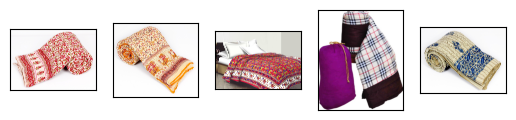

Prithish Coffee Mugs


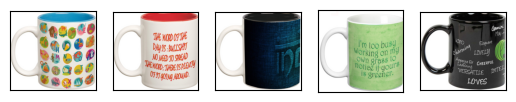

Rockmantra Coffee Mugs


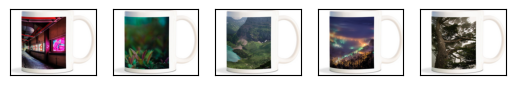

Printland Coffee Mugs


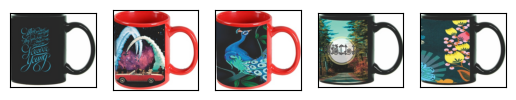

Lal Haveli Ethnic


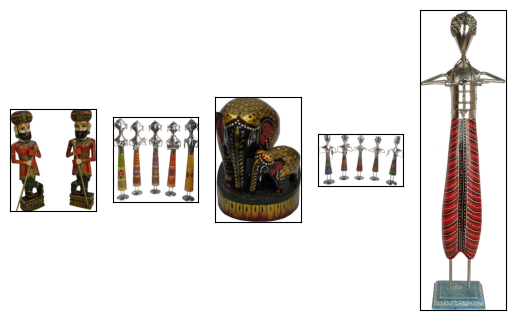

In [70]:
for name in data_little['cat'].unique()[:nb_cat_viz]:
    print(name)
    tmp = list(data_little.loc[data_little['cat']==name, 'img'])
    # print("-------")
    for i in range(nb_img_viz):
        plt.subplot(100 + 1 + i + nb_img_viz*10)
        filename = tmp[i%len(tmp)]
        image = imread(filename)
        
        
        #cacher axes
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        plt.imshow(image)
    plt.show()

## ORB

In [71]:
nb_features = 256

Chargement des images

In [72]:
image_array = []
for path in data_little['img']:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #img = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
    
    #blur_size = int(0.01 * min(img.shape) / 2) * 2 + 1
    #img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
    
    img = cv2.equalizeHist(img)
    
    image_array.append(img)

Extraction des descipteurs

In [73]:
orb = cv2.ORB_create(nfeatures=nb_features)
descriptors = []
for img in image_array:
    kp, des = orb.detectAndCompute(img, None)
    descriptors.append(des)

In [74]:
descriptors_concat = np.concatenate(descriptors, axis=0)

### Version classique

Création des catégories de descripteurs

In [75]:
# On prépare un certain nombre de catégories
nb_clusters_cat = int(np.sqrt(len(descriptors_concat)))

In [76]:
# On entraine un KMean dessus
kmeans = KMeans(n_clusters=nb_clusters_cat, n_init='auto').fit(descriptors_concat)

Création des vecteurs représentant chaque image

In [77]:
histograms = []
# Pour chaque ensemble de descripteurs
# (représentant une image)
for des in descriptors:
    # On trouve le cluster de ces descripteurs
    cluster_indices = kmeans.predict(des)
    # On fait l'histograme
    histogram, _ = np.histogram(cluster_indices, bins=range(nb_clusters_cat+1), density=True)
    # Et on l'ajoute à notre liste
    histograms.append(histogram)
histograms = np.vstack(histograms)

Clustering final des images

In [78]:
predict_ORB = KMeans(n_clusters=nb_cat, n_init='auto').fit_predict(histograms)

In [79]:
predict_ORB = pd.Series(predict_ORB)

In [80]:
predict_ORB

0       8
1      10
2       8
3      11
4      13
       ..
287     2
288    10
289     8
290    18
291     8
Length: 292, dtype: int32

### Version avec moins d'étapes

Prédiction directe des catégories depuis les descripteurs (pas d'histogramme)

In [81]:
kmeans = KMeans(n_clusters=nb_cat, n_init='auto').fit(descriptors_concat)

In [82]:
predict_ORB_short = []

for des in descriptors:
    cluster_indices = kmeans.predict(des)
    histogram, _ = np.histogram(cluster_indices, bins=range(nb_cat+1), density=True)
    predict_ORB_short.append(np.argmax(histogram))

In [83]:
predict_ORB_short = pd.Series(predict_ORB_short)

In [84]:
predict_ORB_short

0       5
1      14
2       8
3       1
4       7
       ..
287    12
288     0
289     9
290    11
291    17
Length: 292, dtype: int64

### Quelques visualisations

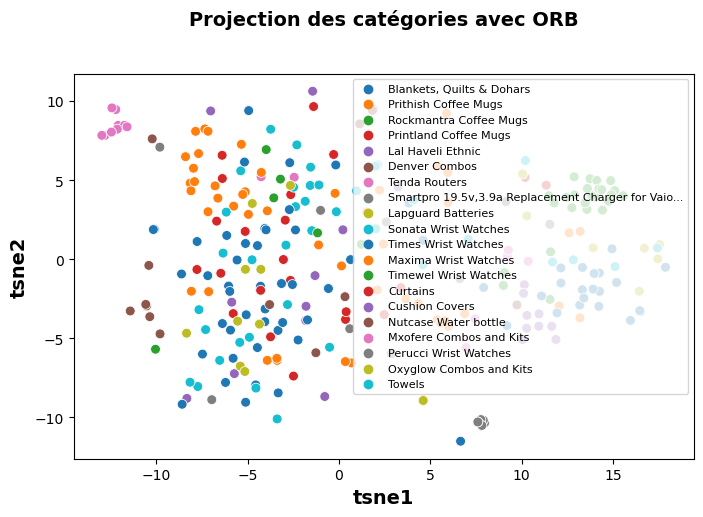

In [85]:
show_representation(histograms, data_little['cat'], title='Projection des catégories avec ORB')
pass

In [86]:
proj_ORB_original = np.copy(histograms)

In [87]:
print("ARI pour ORB :",
      adjusted_rand_score(data_little['label'], predict_ORB))

ARI pour ORB : 0.14052909521978932


In [88]:
print("ARI pour ORB short :",
      adjusted_rand_score(predict_ORB_short, data_little['label']))

ARI pour ORB short : 0.07141061169238914


In [89]:
print("ARI entre les deux types de clustering :", 
      adjusted_rand_score(predict_ORB_short, predict_ORB))

ARI entre les deux types de clustering : 0.17394519189129998


## CNN

Chargement du modele

In [90]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Chargement et transformation des images

In [91]:
images_features = []
i=0 
for path in data_little["img"] :
    if i%25 == 0 : print(i)
    i +=1
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
25
50
75
100
125
150
175
200
225
250
275


(292, 4096)

Réduction de la taille des vecteurs

In [92]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(292, 4096)
(292, 234)


Classification

In [93]:
cls = KMeans(n_clusters=nb_cat, n_init=100)
predict_CNN = cls.fit_predict(feat_pca)

In [94]:
predict_CNN = pd.Series(predict_CNN)

# Comparaison des résultats

In [95]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [96]:
def compare_clustering(original, predict, return_cat=False):
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

Représentation initiale

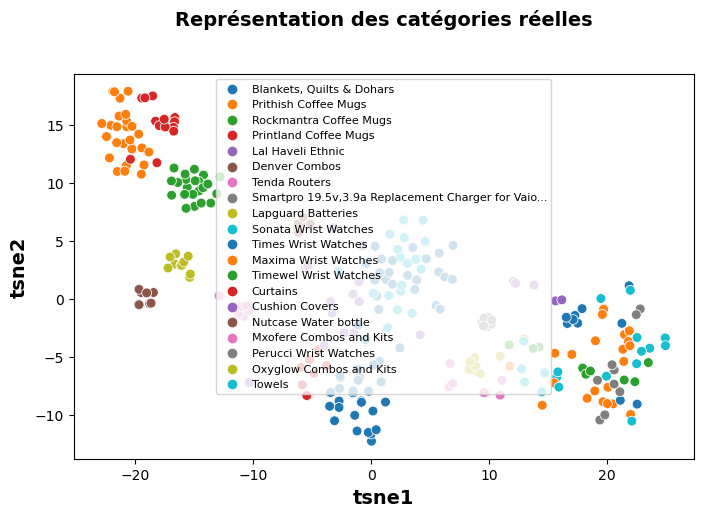

In [97]:
X_tsne = show_representation(feat_pca, data_little['cat'], title="Représentation des catégories réelles")

Clustering en utilisant CNN

In [98]:
list_cat, list_col = compare_clustering(data_little['cat'], predict_CNN, True)
list_trad = [0]*len(list_cat)
for e in range(len(list_cat)):
    i = int(list_col[e][5:])
    list_trad[i] = list_cat[e]

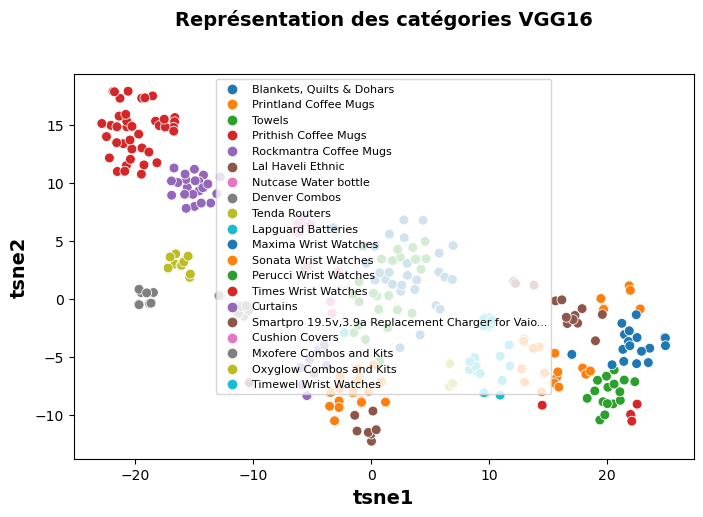

In [99]:
X_tsne = show_representation(feat_pca, predict_CNN.apply(lambda e : list_trad[e]), X_tsne=X_tsne, title="Représentation des catégories VGG16")

In [100]:
compare_clustering(data_little['cat'], predict_CNN)

ARI :  0.4704043508353628


Clustering avec ORB

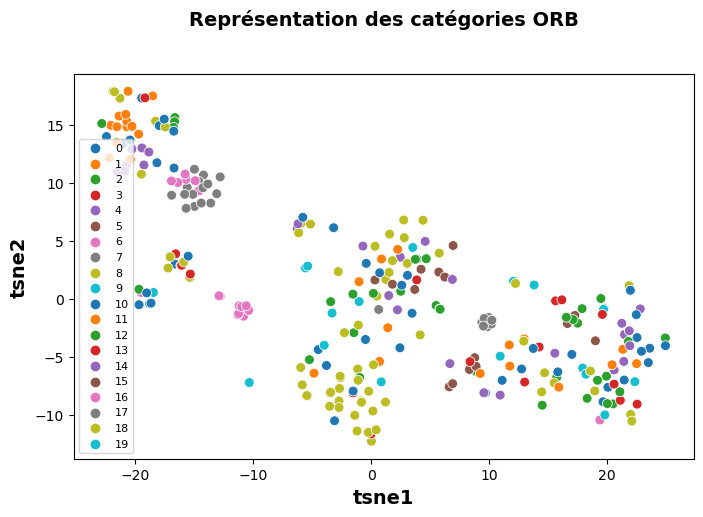

In [101]:
X_tsne = show_representation(feat_pca, predict_ORB, X_tsne=X_tsne, title="Représentation des catégories ORB")

In [102]:
compare_clustering(data_little['cat'], predict_ORB)

ARI :  0.14052909521978932


Visualisation des données mal classées

In [103]:
compare_clustering(data_little['cat'], predict_CNN)

ARI :  0.4704043508353628


In [104]:
list_cat, list_col = compare_clustering(data_little['cat'], predict_CNN, True)

In [105]:
tmp = data_little.copy()

In [106]:
tmp['label'] = tmp['cat'].apply(lambda e : list_cat.index(e))

In [107]:
tmp['pred'] = predict_CNN
tmp['pred'] = tmp['pred'].apply(lambda e : list_col.index('pred_'+str(e)))

In [108]:
@interact
def show_img(reel=list_cat, predit=list_cat, index=range(0, 10)):
    reel = list_cat.index(reel)
    predit = list_cat.index(predit)
    
    l = list(tmp.loc[(tmp['label']==reel) & (tmp['pred']==predit)].index)
    
    print("Nombre de lignes : ", len(l))
    if index >= len(l):
        return None

    print("Index de cette image dans tmp : ", l[index])
    
    return show_from_cv2(image_array[l[index]])

interactive(children=(Dropdown(description='reel', options=('Prithish Coffee Mugs', 'Rockmantra Coffee Mugs', …

# Conversion des images en plus petit

In [109]:
# Répertoire d'entrée contenant les images à redimensionner
input_dir = path_img

# Répertoire de sortie pour les images redimensionnées
output_dir = path_img_little

# Taille cible pour les images redimensionnées
target_size = (500, 500)

# Parcourir le répertoire d'entrée et redimensionner chaque image
for filename in []: # os.listdir(input_dir):
    # Vérifier que le fichier est une image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Ouvrir l'image avec PIL
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)
        # Redimensionner l'image avec la méthode thumbnail de PIL
        image.thumbnail(target_size)
        # Enregistrer l'image redimensionnée dans le répertoire de sortie
        output_path = os.path.join(output_dir, filename)
        image.save(output_path)